In [1]:
# Import necessary packages
using PyPlot
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using AlgebraicMultigrid
using Printf

In [139]:
struct Grid
    x::Vector
    y::Vector
    xc::Vector
    yc::Vector
    nx::Int
    ny::Int
    W::Float64
    H::Float64
    dx::Float64
    dy::Float64
    function Grid(W::Float64,H::Float64,nx::Int,ny::Int)
        dx = W/(nx-1)
        dy = H/(ny-1)
        new(LinRange(0,W,nx),LinRange(0,H,ny),
            LinRange(0-dx/2,W+dx/2,nx+1),LinRange(0-dy/2,H+dy/2,ny+1),
            nx,ny,W,H,W/(nx-1),H/(ny-1))
    end
end

struct BoundaryConditions
    # The intent here is that each boundary gets a flag
    # 0 = Free-slip
    # 1 = No-slip
    # other possibilities?
    top::Int
    bottom::Int
    left::Int
    right::Int
end

function initial_conditions(grid::Grid)
    # Setup the initial density structure
    rho = zeros(grid.ny,grid.nx)
    etaS = ones(grid.ny,grid.nx)
    etaN = ones(grid.ny,grid.nx)
    for i in 1:grid.ny
        for j in 1:grid.nx
            if grid.x[j] < grid.W/2.
                rho[i,j] = 3200.
                etaS[i,j] = 1.0e21
            else
                rho[i,j] = 3300.
                etaS[i,j] = 1.0e21
            end
            if grid.xc[j] < grid.W/2.
                etaN[i,j] = 1.0e21
            else
                etaN[i,j] = 1.0e21
            end
        end
    end
    
    return rho, etaS, etaN
end



function form_stokes(grid::Grid,eta_s::Matrix,eta_n::Matrix,bc::BoundaryConditions,gy::Float64)
    k::Int = 1 # index into dof arrays
    nx = grid.nx
    ny = grid.ny
    nn = nx*ny
    nnz = 2*12*nn + 4*nn # total number of nonzeros in matrix (not including BCs)
    row_index = zeros(Int64,nnz) # up to 5 nonzeros per row
    col_index = zeros(Int64,nnz) 
    value = zeros(Float64, nnz)
    kcont = 2*eta_s[1,1]/(grid.dx+grid.dy)# scaling factor for continuity equation
    kbond = 1.# scaling factor for dirichlet bc equations.

    node_index(i::Int,j::Int) = ny*(j-1)+i
    vxdof(i::Int,j::Int) = 3*(node_index(i,j)-1)+1
    vydof(i::Int,j::Int) = 3*(node_index(i,j)-1)+2
    pdof( i::Int,j::Int) = 3*(node_index(i,j)-1)+3

    R=zeros(3*nn,1)
    
    # loop over j
    for j in 1:nx
        # loop over i
        for i in 1:ny
            dxp = j<nx ? grid.x[j+1] - grid.x[j]   : grid.x[j]   - grid.x[j-1]
            dxm = j>1  ? grid.x[j]   - grid.x[j-1] : grid.x[j+1] - grid.x[j]
            dxc = 0.5*(dxp+dxm)
            dyp = i<ny ? grid.yc[i+1]-grid.yc[i]   : grid.yc[i]   -grid.yc[i-1]
            dym = i>1  ? grid.yc[i] - grid.yc[i-1] : grid.yc[i+1] -grid.yc[i]
            dyc = 0.5*(dyp+dym)

            # discretize the x-stokes - note that numbering in comments refers to Gerya Figure 7.18a
            # and equation 7.22
            this_row = vxdof(i,j)
            # Boundary cases first...            
            if j==1 || j == nx # left boundary or right boundary
                # vx = 0
                row_index[k] = this_row
                col_index[k] = this_row
                value[k] = kbond
                k+=1
                R[this_row] = 0.0 *kbond
            elseif i==1
                # dvx/dy = 0 (free slip)
                row_index[k] = this_row
                col_index[k] = this_row
                value[k] = kbond
                k+=1
                row_index[k] = this_row
                col_index[k] = vxdof(i+1,j)
                value[k] = -kbond
                k+=1                
                R[this_row] = 0.0 *kbond
            else
            # vx1
            row_index[k] = this_row
            col_index[k] = vxdof(i,j-1)
            value[k] = 2*eta_n[i,j]/dxm/dxc
            k+=1
            # vx2
            row_index[k] = this_row
            col_index[k] = vxdof(i-1,j)
            value[k] = eta_s[i-1,j]/dym/dyc
            k+=1
            # vx3
            row_index[k] = this_row
            col_index[k] = this_row
            value[k] = -2*eta_n[i,j+1]/dxp/dxc -2*eta_n[i,j]/dxm/dxc - eta_s[i,j]/dyp/dyc - eta_s[i-1,j]/dym/dyc
            if i == nx
                # if i == nx, dvx/dy = 0 -> vx3 == vx4 (see Gerya fig 7.18a)
                value[k] += eta_s[i,j]/dyp/dyc
            end
            k+=1                
            # vx4
            if i<ny
                # enforce dvx/dy = 0 (free slip)                
                row_index[k] = this_row
                col_index[k] = vxdof(i+1,j)
                value[k] = eta_s[i,j]/dyp/dyc
                k+=1
            end
                    
            # vx5
            row_index[k] = this_row
            col_index[k] = vxdof(i,j+1)
            value[k] = 2*eta_n[i,j+1]/dxp/dxc
            k+=1
            # vy1
            row_index[k] = this_row
            col_index[k] = vydof(i-1,j)
            value[k] = eta_s[i-1,j]/dxc/dyc
            k+=1
            # vy2
            row_index[k] = this_row
            col_index[k] = vydof(i,j)
            value[k] = -eta_s[i,j]/dxc/dyc
            k+=1
            # vy3
            row_index[k] = this_row
            col_index[k] = vydof(i-1,j+1)
            value[k] = -eta_s[i-1,j]/dxc/dyc
            k+=1
            # vy4
            row_index[k] = this_row
            col_index[k] = vydof(i,j+1)
            value[k] = eta_s[i,j]/dxc/dyc           
            k+=1
            # P1
            row_index[k] = this_row
            col_index[k] = pdof(i,j)
            value[k] = kcont/dxc
            k+=1
            # P2
            row_index[k] = this_row
            col_index[k] = pdof(i,j+1)
            value[k] = -kcont/dxc
            k+=1
            
            R[this_row] = 0.
            end
            # END X-STOKES
            
            # BEGIN Y-STOKES
            this_row = vydof(i,j)
            if i==1 || i == ny
                # top row / bottom row
                row_index[k] = this_row
                col_index[k] = this_row
                value[k] = kbond
                k+=1
                R[this_row] = 0.0*kbond
            elseif j==1
                # left boundary - free slip
                row_index[k] = this_row
                col_index[k] = this_row
                value[k] = kbond
                k+=1
                row_index[k] = this_row
                col_index[k] = vydof(i,j+1)
                value[k] = -kbond
                k+=1
                R[this_row] = 0.0*kbond
            else            
                #vy1
                row_index[k] = this_row
                col_index[k] = vydof(i,j-1)
                value[k] = eta_s[i,j-1]/dxm/dxc
                k+=1
                #vy2
                row_index[k] = this_row
                col_index[k] = vydof(i-1,j)
                value[k] = 2*eta_n[i,j]/dym/dyc
                k+=1
                #vy3
                row_index[k] = this_row
                col_index[k] = vydof(i,j)
                value[k] = -2*eta_n[i+1,j]/dyp/dyc -2*eta_n[i,j]/dym/dyc - eta_s[i,j]/dxp/dxc - eta_s[i,j-1]/dxm/dxc
                if j == nx
                    # free slip - vx5 = vx3.
                   value[k] += eta_s[i,j]/dxp/dxc
                end
                k+=1
                
                #vy4
                row_index[k] = this_row
                col_index[k] = vydof(i+1,j)
                value[k] = 2*eta_n[i+1,j]/dyp/dyc
                k+=1
                #vy5
                if j<nx
                row_index[k] = this_row
                col_index[k] = vydof(i,j+1)
                value[k] = eta_s[i,j]/dxp/dxc
                k+=1
                end
                #vx1
                row_index[k] = this_row
                col_index[k] = vxdof(i,j-1)
                value[k] = eta_s[i,j-1]/dxc/dyc
                k+=1
                #vx2
                row_index[k] = this_row
                col_index[k] = vxdof(i+1,j)
                value[k] = -eta_s[i,j-1]/dxc/dyc
                k+=1
                #vx3
                row_index[k] = this_row
                col_index[k] = vxdof(i,j)
                value[k] = -eta_s[i,j]/dxc/dyc
                k+=1
                #vx4
                row_index[k] = this_row
                col_index[k] = vxdof(i+1,j)
                value[k] = eta_s[i,j]/dxc/dyc
                k+=1
                #P1
                row_index[k] = this_row
                col_index[k] = pdof(i,j)
                value[k] = kcont/dyc
                k+=1
                #P2
                row_index[k] = this_row
                col_index[k] = pdof(i+1,j)
                value[k] = -kcont/dyc
                k+=1

                R[this_row] = -gy*(rho[i,j-1]+rho[i,j])/2.
            end
            # END Y-STOKES
            
            # discretize the continuity equation
            # dvx/dx + dvy/dy = 0
            this_row = pdof(i,j)
            if i==1 || j == 1 || (i==2 && j == 2)
                row_index[k] = this_row
                col_index[k] = this_row
                value[k] =  kbond
                k+=1  
                R[this_row] = 0.0
            else
                row_index[k] = this_row
                col_index[k] = vxdof(i,j)
                value[k] =  kcont/dxm
                k+=1

                row_index[k] = this_row
                col_index[k] = vxdof(i,j-1)
                value[k] = -kcont/dxm
                k+=1

                row_index[k] = this_row
                col_index[k] = vydof(i,j)
                value[k] =  kcont/dym
                k+=1

                row_index[k] = this_row
                col_index[k] = vydof(i-1,j)
                value[k] = -kcont/dym
                k+=1

                R[this_row] = 0.0
            end
            # END CONTINUITY
            
        end
    end
    @views row_index = row_index[1:(k-1)]
    @views col_index = col_index[1:(k-1)]
    @views value = value[1:(k-1)]

    L = sparse(row_index,col_index,value)
    return L,R    
end

function unpack(solution, grid::Grid)
    P = zeros(Float64,(grid.ny,grid.nx))
    vx = zeros(Float64,(grid.ny,grid.nx))
    vy = zeros(Float64,(grid.ny,grid.nx))
    ny = grid.ny
    for i in 1:grid.ny
        for j in 1:grid.nx
            ind = 3*((j-1)*ny+i-1)+1
            vx[i,j] = solution[ind]
            vy[i,j] = solution[ind+1]
            P[i,j]  = solution[ind+2]            
        end
    end
    return vx,vy,P
end

unpack (generic function with 1 method)

In [148]:
# Set up the grid
nx = 41
ny = 41
W = 1e6
H = 1.0e6
gy = 10.0
grid = Grid(W,H,nx,ny)
rho,eta_s,eta_n = initial_conditions(grid)
bc = BoundaryConditions(0,0,0,0)
L,R = form_stokes(grid,eta_s,eta_n,bc,gy)
solution = L\R
vx,vy,P = unpack(solution,grid)

([0.0 1.3170427261998316e-9 … 1.2341955267816781e-9 0.0; 0.0 1.3170427261998316e-9 … 1.2341955267816781e-9 0.0; … ; 0.0 -3.3670632252105756e-10 … -3.217385705494524e-10 0.0; 0.0 -3.346497388587176e-10 … -3.1969543545489653e-10 0.0], [0.0 0.0 … 0.0 0.0; -1.317042726199813e-9 -1.317042726199813e-9 … 1.2369520646588434e-9 1.2341955267816781e-9; … ; -3.346497388587176e-10 -3.346497388587176e-10 … 3.195138355170196e-10 3.1969543545489653e-10; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … -1.801727091677621e-8 -1.8035247575662085e-8; … ; 0.0 7.62875716837906e-7 … 7.630516297283192e-7 7.630499393512687e-7; 0.0 7.832085015132767e-7 … 7.833589669861271e-7 7.833571054509704e-7])

In [149]:

for i in 1:grid.nx*grid.ny
    println(i," ",L[3*(i-1)+3,:])
end

1   [3   ]  =  1.0
2   [6   ]  =  1.0
3   [9   ]  =  1.0
4   [12  ]  =  1.0
5   [15  ]  =  1.0
6   [18  ]  =  1.0
7   [21  ]  =  1.0
8   [24  ]  =  1.0
9   [27  ]  =  1.0
10   [30  ]  =  1.0
11   [33  ]  =  1.0
12   [36  ]  =  1.0
13   [39  ]  =  1.0
14   [42  ]  =  1.0
15   [45  ]  =  1.0
16   [48  ]  =  1.0
17   [51  ]  =  1.0
18   [54  ]  =  1.0
19   [57  ]  =  1.0
20   [60  ]  =  1.0
21   [63  ]  =  1.0
22   [66  ]  =  1.0
23   [69  ]  =  1.0
24   [72  ]  =  1.0
25   [75  ]  =  1.0
26   [78  ]  =  1.0
27   [81  ]  =  1.0
28   [84  ]  =  1.0
29   [87  ]  =  1.0
30   [90  ]  =  1.0
31   [93  ]  =  1.0
32   [96  ]  =  1.0
33   [99  ]  =  1.0
34   [102 ]  =  1.0
35   [105 ]  =  1.0
36   [108 ]  =  1.0
37   [111 ]  =  1.0
38   [114 ]  =  1.0
39   [117 ]  =  1.0
40   [120 ]  =  1.0
41   [123 ]  =  1.0
42   [126 ]  =  1.0
43   [129 ]  =  1.0
44   [7   ]  =  -1.6e12
  [128 ]  =  -1.6e12
  [130 ]  =  1.6e12
  [131 ]  =  1.6e12
45   [10  ]  =  -1.6e12
  [131 ]  =  -1.6e12
  [133 ]  =  1.6e12

  [461 ]  =  -1.6e12
  [463 ]  =  1.6e12
  [464 ]  =  1.6e12
156   [343 ]  =  -1.6e12
  [464 ]  =  -1.6e12
  [466 ]  =  1.6e12
  [467 ]  =  1.6e12
157   [346 ]  =  -1.6e12
  [467 ]  =  -1.6e12
  [469 ]  =  1.6e12
  [470 ]  =  1.6e12
158   [349 ]  =  -1.6e12
  [470 ]  =  -1.6e12
  [472 ]  =  1.6e12
  [473 ]  =  1.6e12
159   [352 ]  =  -1.6e12
  [473 ]  =  -1.6e12
  [475 ]  =  1.6e12
  [476 ]  =  1.6e12
160   [355 ]  =  -1.6e12
  [476 ]  =  -1.6e12
  [478 ]  =  1.6e12
  [479 ]  =  1.6e12
161   [358 ]  =  -1.6e12
  [479 ]  =  -1.6e12
  [481 ]  =  1.6e12
  [482 ]  =  1.6e12
162   [361 ]  =  -1.6e12
  [482 ]  =  -1.6e12
  [484 ]  =  1.6e12
  [485 ]  =  1.6e12
163   [364 ]  =  -1.6e12
  [485 ]  =  -1.6e12
  [487 ]  =  1.6e12
  [488 ]  =  1.6e12
164   [367 ]  =  -1.6e12
  [488 ]  =  -1.6e12
  [490 ]  =  1.6e12
  [491 ]  =  1.6e12
165   [495 ]  =  1.0
166   [373 ]  =  -1.6e12
  [494 ]  =  -1.6e12
  [496 ]  =  1.6e12
  [497 ]  =  1.6e12
167   [376 ]  =  -1.6e12
  [497 ]  =  -1.6e12
  [499 ]  = 

  [827 ]  =  1.6e12
277   [706 ]  =  -1.6e12
  [827 ]  =  -1.6e12
  [829 ]  =  1.6e12
  [830 ]  =  1.6e12
278   [709 ]  =  -1.6e12
  [830 ]  =  -1.6e12
  [832 ]  =  1.6e12
  [833 ]  =  1.6e12
279   [712 ]  =  -1.6e12
  [833 ]  =  -1.6e12
  [835 ]  =  1.6e12
  [836 ]  =  1.6e12
280   [715 ]  =  -1.6e12
  [836 ]  =  -1.6e12
  [838 ]  =  1.6e12
  [839 ]  =  1.6e12
281   [718 ]  =  -1.6e12
  [839 ]  =  -1.6e12
  [841 ]  =  1.6e12
  [842 ]  =  1.6e12
282   [721 ]  =  -1.6e12
  [842 ]  =  -1.6e12
  [844 ]  =  1.6e12
  [845 ]  =  1.6e12
283   [724 ]  =  -1.6e12
  [845 ]  =  -1.6e12
  [847 ]  =  1.6e12
  [848 ]  =  1.6e12
284   [727 ]  =  -1.6e12
  [848 ]  =  -1.6e12
  [850 ]  =  1.6e12
  [851 ]  =  1.6e12
285   [730 ]  =  -1.6e12
  [851 ]  =  -1.6e12
  [853 ]  =  1.6e12
  [854 ]  =  1.6e12
286   [733 ]  =  -1.6e12
  [854 ]  =  -1.6e12
  [856 ]  =  1.6e12
  [857 ]  =  1.6e12
287   [736 ]  =  -1.6e12
  [857 ]  =  -1.6e12
  [859 ]  =  1.6e12
  [860 ]  =  1.6e12
288   [864 ]  =  1.0
289   [742 ] 

398   [1069]  =  -1.6e12
  [1190]  =  -1.6e12
  [1192]  =  1.6e12
  [1193]  =  1.6e12
399   [1072]  =  -1.6e12
  [1193]  =  -1.6e12
  [1195]  =  1.6e12
  [1196]  =  1.6e12
400   [1075]  =  -1.6e12
  [1196]  =  -1.6e12
  [1198]  =  1.6e12
  [1199]  =  1.6e12
401   [1078]  =  -1.6e12
  [1199]  =  -1.6e12
  [1201]  =  1.6e12
  [1202]  =  1.6e12
402   [1081]  =  -1.6e12
  [1202]  =  -1.6e12
  [1204]  =  1.6e12
  [1205]  =  1.6e12
403   [1084]  =  -1.6e12
  [1205]  =  -1.6e12
  [1207]  =  1.6e12
  [1208]  =  1.6e12
404   [1087]  =  -1.6e12
  [1208]  =  -1.6e12
  [1210]  =  1.6e12
  [1211]  =  1.6e12
405   [1090]  =  -1.6e12
  [1211]  =  -1.6e12
  [1213]  =  1.6e12
  [1214]  =  1.6e12
406   [1093]  =  -1.6e12
  [1214]  =  -1.6e12
  [1216]  =  1.6e12
  [1217]  =  1.6e12
407   [1096]  =  -1.6e12
  [1217]  =  -1.6e12
  [1219]  =  1.6e12
  [1220]  =  1.6e12
408   [1099]  =  -1.6e12
  [1220]  =  -1.6e12
  [1222]  =  1.6e12
  [1223]  =  1.6e12
409   [1102]  =  -1.6e12
  [1223]  =  -1.6e12
  [1225]

  [1555]  =  1.6e12
  [1556]  =  1.6e12
520   [1435]  =  -1.6e12
  [1556]  =  -1.6e12
  [1558]  =  1.6e12
  [1559]  =  1.6e12
521   [1438]  =  -1.6e12
  [1559]  =  -1.6e12
  [1561]  =  1.6e12
  [1562]  =  1.6e12
522   [1441]  =  -1.6e12
  [1562]  =  -1.6e12
  [1564]  =  1.6e12
  [1565]  =  1.6e12
523   [1444]  =  -1.6e12
  [1565]  =  -1.6e12
  [1567]  =  1.6e12
  [1568]  =  1.6e12
524   [1447]  =  -1.6e12
  [1568]  =  -1.6e12
  [1570]  =  1.6e12
  [1571]  =  1.6e12
525   [1450]  =  -1.6e12
  [1571]  =  -1.6e12
  [1573]  =  1.6e12
  [1574]  =  1.6e12
526   [1453]  =  -1.6e12
  [1574]  =  -1.6e12
  [1576]  =  1.6e12
  [1577]  =  1.6e12
527   [1456]  =  -1.6e12
  [1577]  =  -1.6e12
  [1579]  =  1.6e12
  [1580]  =  1.6e12
528   [1459]  =  -1.6e12
  [1580]  =  -1.6e12
  [1582]  =  1.6e12
  [1583]  =  1.6e12
529   [1462]  =  -1.6e12
  [1583]  =  -1.6e12
  [1585]  =  1.6e12
  [1586]  =  1.6e12
530   [1465]  =  -1.6e12
  [1586]  =  -1.6e12
  [1588]  =  1.6e12
  [1589]  =  1.6e12
531   [1468]  

  [1919]  =  1.6e12
641   [1798]  =  -1.6e12
  [1919]  =  -1.6e12
  [1921]  =  1.6e12
  [1922]  =  1.6e12
642   [1801]  =  -1.6e12
  [1922]  =  -1.6e12
  [1924]  =  1.6e12
  [1925]  =  1.6e12
643   [1804]  =  -1.6e12
  [1925]  =  -1.6e12
  [1927]  =  1.6e12
  [1928]  =  1.6e12
644   [1807]  =  -1.6e12
  [1928]  =  -1.6e12
  [1930]  =  1.6e12
  [1931]  =  1.6e12
645   [1810]  =  -1.6e12
  [1931]  =  -1.6e12
  [1933]  =  1.6e12
  [1934]  =  1.6e12
646   [1813]  =  -1.6e12
  [1934]  =  -1.6e12
  [1936]  =  1.6e12
  [1937]  =  1.6e12
647   [1816]  =  -1.6e12
  [1937]  =  -1.6e12
  [1939]  =  1.6e12
  [1940]  =  1.6e12
648   [1819]  =  -1.6e12
  [1940]  =  -1.6e12
  [1942]  =  1.6e12
  [1943]  =  1.6e12
649   [1822]  =  -1.6e12
  [1943]  =  -1.6e12
  [1945]  =  1.6e12
  [1946]  =  1.6e12
650   [1825]  =  -1.6e12
  [1946]  =  -1.6e12
  [1948]  =  1.6e12
  [1949]  =  1.6e12
651   [1828]  =  -1.6e12
  [1949]  =  -1.6e12
  [1951]  =  1.6e12
  [1952]  =  1.6e12
652   [1831]  =  -1.6e12
  [1952] 

  [2282]  =  -1.6e12
  [2284]  =  1.6e12
  [2285]  =  1.6e12
763   [2164]  =  -1.6e12
  [2285]  =  -1.6e12
  [2287]  =  1.6e12
  [2288]  =  1.6e12
764   [2167]  =  -1.6e12
  [2288]  =  -1.6e12
  [2290]  =  1.6e12
  [2291]  =  1.6e12
765   [2170]  =  -1.6e12
  [2291]  =  -1.6e12
  [2293]  =  1.6e12
  [2294]  =  1.6e12
766   [2173]  =  -1.6e12
  [2294]  =  -1.6e12
  [2296]  =  1.6e12
  [2297]  =  1.6e12
767   [2176]  =  -1.6e12
  [2297]  =  -1.6e12
  [2299]  =  1.6e12
  [2300]  =  1.6e12
768   [2179]  =  -1.6e12
  [2300]  =  -1.6e12
  [2302]  =  1.6e12
  [2303]  =  1.6e12
769   [2182]  =  -1.6e12
  [2303]  =  -1.6e12
  [2305]  =  1.6e12
  [2306]  =  1.6e12
770   [2185]  =  -1.6e12
  [2306]  =  -1.6e12
  [2308]  =  1.6e12
  [2309]  =  1.6e12
771   [2188]  =  -1.6e12
  [2309]  =  -1.6e12
  [2311]  =  1.6e12
  [2312]  =  1.6e12
772   [2191]  =  -1.6e12
  [2312]  =  -1.6e12
  [2314]  =  1.6e12
  [2315]  =  1.6e12
773   [2194]  =  -1.6e12
  [2315]  =  -1.6e12
  [2317]  =  1.6e12
  [2318]  =  

  [2647]  =  1.6e12
  [2648]  =  1.6e12
884   [2527]  =  -1.6e12
  [2648]  =  -1.6e12
  [2650]  =  1.6e12
  [2651]  =  1.6e12
885   [2530]  =  -1.6e12
  [2651]  =  -1.6e12
  [2653]  =  1.6e12
  [2654]  =  1.6e12
886   [2533]  =  -1.6e12
  [2654]  =  -1.6e12
  [2656]  =  1.6e12
  [2657]  =  1.6e12
887   [2536]  =  -1.6e12
  [2657]  =  -1.6e12
  [2659]  =  1.6e12
  [2660]  =  1.6e12
888   [2539]  =  -1.6e12
  [2660]  =  -1.6e12
  [2662]  =  1.6e12
  [2663]  =  1.6e12
889   [2542]  =  -1.6e12
  [2663]  =  -1.6e12
  [2665]  =  1.6e12
  [2666]  =  1.6e12
890   [2545]  =  -1.6e12
  [2666]  =  -1.6e12
  [2668]  =  1.6e12
  [2669]  =  1.6e12
891   [2548]  =  -1.6e12
  [2669]  =  -1.6e12
  [2671]  =  1.6e12
  [2672]  =  1.6e12
892   [2551]  =  -1.6e12
  [2672]  =  -1.6e12
  [2674]  =  1.6e12
  [2675]  =  1.6e12
893   [2554]  =  -1.6e12
  [2675]  =  -1.6e12
  [2677]  =  1.6e12
  [2678]  =  1.6e12
894   [2557]  =  -1.6e12
  [2678]  =  -1.6e12
  [2680]  =  1.6e12
  [2681]  =  1.6e12
895   [2560]  

1005   [2890]  =  -1.6e12
  [3011]  =  -1.6e12
  [3013]  =  1.6e12
  [3014]  =  1.6e12
1006   [2893]  =  -1.6e12
  [3014]  =  -1.6e12
  [3016]  =  1.6e12
  [3017]  =  1.6e12
1007   [2896]  =  -1.6e12
  [3017]  =  -1.6e12
  [3019]  =  1.6e12
  [3020]  =  1.6e12
1008   [2899]  =  -1.6e12
  [3020]  =  -1.6e12
  [3022]  =  1.6e12
  [3023]  =  1.6e12
1009   [2902]  =  -1.6e12
  [3023]  =  -1.6e12
  [3025]  =  1.6e12
  [3026]  =  1.6e12
1010   [2905]  =  -1.6e12
  [3026]  =  -1.6e12
  [3028]  =  1.6e12
  [3029]  =  1.6e12
1011   [2908]  =  -1.6e12
  [3029]  =  -1.6e12
  [3031]  =  1.6e12
  [3032]  =  1.6e12
1012   [2911]  =  -1.6e12
  [3032]  =  -1.6e12
  [3034]  =  1.6e12
  [3035]  =  1.6e12
1013   [2914]  =  -1.6e12
  [3035]  =  -1.6e12
  [3037]  =  1.6e12
  [3038]  =  1.6e12
1014   [2917]  =  -1.6e12
  [3038]  =  -1.6e12
  [3040]  =  1.6e12
  [3041]  =  1.6e12
1015   [2920]  =  -1.6e12
  [3041]  =  -1.6e12
  [3043]  =  1.6e12
  [3044]  =  1.6e12
1016   [2923]  =  -1.6e12
  [3044]  =  -1.6

1125   [3250]  =  -1.6e12
  [3371]  =  -1.6e12
  [3373]  =  1.6e12
  [3374]  =  1.6e12
1126   [3253]  =  -1.6e12
  [3374]  =  -1.6e12
  [3376]  =  1.6e12
  [3377]  =  1.6e12
1127   [3256]  =  -1.6e12
  [3377]  =  -1.6e12
  [3379]  =  1.6e12
  [3380]  =  1.6e12
1128   [3259]  =  -1.6e12
  [3380]  =  -1.6e12
  [3382]  =  1.6e12
  [3383]  =  1.6e12
1129   [3262]  =  -1.6e12
  [3383]  =  -1.6e12
  [3385]  =  1.6e12
  [3386]  =  1.6e12
1130   [3265]  =  -1.6e12
  [3386]  =  -1.6e12
  [3388]  =  1.6e12
  [3389]  =  1.6e12
1131   [3268]  =  -1.6e12
  [3389]  =  -1.6e12
  [3391]  =  1.6e12
  [3392]  =  1.6e12
1132   [3271]  =  -1.6e12
  [3392]  =  -1.6e12
  [3394]  =  1.6e12
  [3395]  =  1.6e12
1133   [3274]  =  -1.6e12
  [3395]  =  -1.6e12
  [3397]  =  1.6e12
  [3398]  =  1.6e12
1134   [3277]  =  -1.6e12
  [3398]  =  -1.6e12
  [3400]  =  1.6e12
  [3401]  =  1.6e12
1135   [3280]  =  -1.6e12
  [3401]  =  -1.6e12
  [3403]  =  1.6e12
  [3404]  =  1.6e12
1136   [3283]  =  -1.6e12
  [3404]  =  -1.6

1245   [3610]  =  -1.6e12
  [3731]  =  -1.6e12
  [3733]  =  1.6e12
  [3734]  =  1.6e12
1246   [3613]  =  -1.6e12
  [3734]  =  -1.6e12
  [3736]  =  1.6e12
  [3737]  =  1.6e12
1247   [3616]  =  -1.6e12
  [3737]  =  -1.6e12
  [3739]  =  1.6e12
  [3740]  =  1.6e12
1248   [3619]  =  -1.6e12
  [3740]  =  -1.6e12
  [3742]  =  1.6e12
  [3743]  =  1.6e12
1249   [3622]  =  -1.6e12
  [3743]  =  -1.6e12
  [3745]  =  1.6e12
  [3746]  =  1.6e12
1250   [3625]  =  -1.6e12
  [3746]  =  -1.6e12
  [3748]  =  1.6e12
  [3749]  =  1.6e12
1251   [3628]  =  -1.6e12
  [3749]  =  -1.6e12
  [3751]  =  1.6e12
  [3752]  =  1.6e12
1252   [3631]  =  -1.6e12
  [3752]  =  -1.6e12
  [3754]  =  1.6e12
  [3755]  =  1.6e12
1253   [3634]  =  -1.6e12
  [3755]  =  -1.6e12
  [3757]  =  1.6e12
  [3758]  =  1.6e12
1254   [3637]  =  -1.6e12
  [3758]  =  -1.6e12
  [3760]  =  1.6e12
  [3761]  =  1.6e12
1255   [3640]  =  -1.6e12
  [3761]  =  -1.6e12
  [3763]  =  1.6e12
  [3764]  =  1.6e12
1256   [3643]  =  -1.6e12
  [3764]  =  -1.6

1365   [3970]  =  -1.6e12
  [4091]  =  -1.6e12
  [4093]  =  1.6e12
  [4094]  =  1.6e12
1366   [3973]  =  -1.6e12
  [4094]  =  -1.6e12
  [4096]  =  1.6e12
  [4097]  =  1.6e12
1367   [3976]  =  -1.6e12
  [4097]  =  -1.6e12
  [4099]  =  1.6e12
  [4100]  =  1.6e12
1368   [3979]  =  -1.6e12
  [4100]  =  -1.6e12
  [4102]  =  1.6e12
  [4103]  =  1.6e12
1369   [3982]  =  -1.6e12
  [4103]  =  -1.6e12
  [4105]  =  1.6e12
  [4106]  =  1.6e12
1370   [3985]  =  -1.6e12
  [4106]  =  -1.6e12
  [4108]  =  1.6e12
  [4109]  =  1.6e12
1371   [3988]  =  -1.6e12
  [4109]  =  -1.6e12
  [4111]  =  1.6e12
  [4112]  =  1.6e12
1372   [3991]  =  -1.6e12
  [4112]  =  -1.6e12
  [4114]  =  1.6e12
  [4115]  =  1.6e12
1373   [3994]  =  -1.6e12
  [4115]  =  -1.6e12
  [4117]  =  1.6e12
  [4118]  =  1.6e12
1374   [3997]  =  -1.6e12
  [4118]  =  -1.6e12
  [4120]  =  1.6e12
  [4121]  =  1.6e12
1375   [4000]  =  -1.6e12
  [4121]  =  -1.6e12
  [4123]  =  1.6e12
  [4124]  =  1.6e12
1376   [4003]  =  -1.6e12
  [4124]  =  -1.6

1485   [4330]  =  -1.6e12
  [4451]  =  -1.6e12
  [4453]  =  1.6e12
  [4454]  =  1.6e12
1486   [4333]  =  -1.6e12
  [4454]  =  -1.6e12
  [4456]  =  1.6e12
  [4457]  =  1.6e12
1487   [4336]  =  -1.6e12
  [4457]  =  -1.6e12
  [4459]  =  1.6e12
  [4460]  =  1.6e12
1488   [4339]  =  -1.6e12
  [4460]  =  -1.6e12
  [4462]  =  1.6e12
  [4463]  =  1.6e12
1489   [4342]  =  -1.6e12
  [4463]  =  -1.6e12
  [4465]  =  1.6e12
  [4466]  =  1.6e12
1490   [4345]  =  -1.6e12
  [4466]  =  -1.6e12
  [4468]  =  1.6e12
  [4469]  =  1.6e12
1491   [4348]  =  -1.6e12
  [4469]  =  -1.6e12
  [4471]  =  1.6e12
  [4472]  =  1.6e12
1492   [4351]  =  -1.6e12
  [4472]  =  -1.6e12
  [4474]  =  1.6e12
  [4475]  =  1.6e12
1493   [4354]  =  -1.6e12
  [4475]  =  -1.6e12
  [4477]  =  1.6e12
  [4478]  =  1.6e12
1494   [4357]  =  -1.6e12
  [4478]  =  -1.6e12
  [4480]  =  1.6e12
  [4481]  =  1.6e12
1495   [4360]  =  -1.6e12
  [4481]  =  -1.6e12
  [4483]  =  1.6e12
  [4484]  =  1.6e12
1496   [4363]  =  -1.6e12
  [4484]  =  -1.6

1605   [4690]  =  -1.6e12
  [4811]  =  -1.6e12
  [4813]  =  1.6e12
  [4814]  =  1.6e12
1606   [4693]  =  -1.6e12
  [4814]  =  -1.6e12
  [4816]  =  1.6e12
  [4817]  =  1.6e12
1607   [4696]  =  -1.6e12
  [4817]  =  -1.6e12
  [4819]  =  1.6e12
  [4820]  =  1.6e12
1608   [4699]  =  -1.6e12
  [4820]  =  -1.6e12
  [4822]  =  1.6e12
  [4823]  =  1.6e12
1609   [4702]  =  -1.6e12
  [4823]  =  -1.6e12
  [4825]  =  1.6e12
  [4826]  =  1.6e12
1610   [4705]  =  -1.6e12
  [4826]  =  -1.6e12
  [4828]  =  1.6e12
  [4829]  =  1.6e12
1611   [4708]  =  -1.6e12
  [4829]  =  -1.6e12
  [4831]  =  1.6e12
  [4832]  =  1.6e12
1612   [4711]  =  -1.6e12
  [4832]  =  -1.6e12
  [4834]  =  1.6e12
  [4835]  =  1.6e12
1613   [4714]  =  -1.6e12
  [4835]  =  -1.6e12
  [4837]  =  1.6e12
  [4838]  =  1.6e12
1614   [4717]  =  -1.6e12
  [4838]  =  -1.6e12
  [4840]  =  1.6e12
  [4841]  =  1.6e12
1615   [4720]  =  -1.6e12
  [4841]  =  -1.6e12
  [4843]  =  1.6e12
  [4844]  =  1.6e12
1616   [4723]  =  -1.6e12
  [4844]  =  -1.6

vy

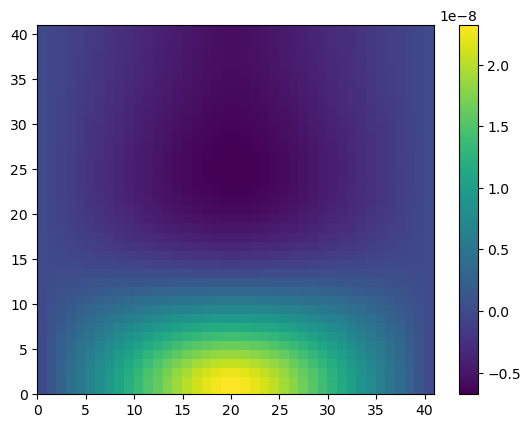

In [156]:
figure()
pcolor(vx)
colorbar()
show()